In [1]:
import numpy as np 
import os
import matplotlib.pyplot as plt
import cv2
import glob
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
DATASET = 'STARE'

if DATASET == 'MENDELEY':
    PATH = '/content/drive/MyDrive/AV_split/'
    TRAIN_PATH = PATH+'train/'
    TRAIN_IMAGE_PATH = TRAIN_PATH + 'images'
    TRAIN_MASK_PATH = TRAIN_PATH + 'GT_vessel'
    SIZE = 512
    
    TEST_PATH = PATH+'test/'
    TEST_IMAGE_PATH = TEST_PATH + 'images'
    TEST_MASK_PATH = TEST_PATH + 'GT_vessel'
    SAVE_TEST_IMAGE_PATH = TEST_PATH + 'predict'
    
elif DATASET == 'STARE':
    PATH = '/content/drive/MyDrive/STARE/'
    TRAIN_PATH = PATH+'train/'
    TRAIN_IMAGE_PATH = TRAIN_PATH + 'images'
    TRAIN_MASK_PATH = TRAIN_PATH + 'GT'
    SIZE = 512
    
    TEST_PATH = PATH+'test/'
    TEST_IMAGE_PATH = TEST_PATH + 'images'
    TEST_MASK_PATH = TEST_PATH + 'GT'
    SAVE_TEST_IMAGE_PATH = TEST_PATH + 'predict'

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def clahe_equalized(image):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    image_equalized = clahe.apply(image)
    
    return image_equalized

def image_aug(image):
    image = image[:,:,1]
    image = clahe_equalized(image)

    # av_split img shaoe 1000, 1504
    if DATASET == 'MENDELEY':
      image = image[70:970, 200:1255]

    image = cv2.resize(image, (512, 512))
    image = np.reshape(image, image.shape + (1,))

    image = image / 255
    return image

def read_image(image_full_path):
    image = cv2.imread(
      image_full_path
    )
    image = image_aug(image)

    return image

# example
if DATASET == 'MENDELEY':
  image = read_image(
    '/content/drive/MyDrive/AV_split/train/images/IM000001.JPG', 
  )
elif DATASET == 'STARE':
  image = read_image(
    '/content/drive/MyDrive/STARE/train/images/im0001.ppm', 
  )

print(image.min(), image.max())
print(image.shape)
print(np.unique(image))

0.011764705882352941 0.9921568627450981
(512, 512, 1)
[0.01176471 0.01568627 0.01960784 0.02352941 0.02745098 0.03137255
 0.03529412 0.03921569 0.04313725 0.04705882 0.05098039 0.05490196
 0.05882353 0.0627451  0.06666667 0.07058824 0.0745098  0.07843137
 0.08235294 0.08627451 0.09019608 0.09411765 0.09803922 0.10196078
 0.10588235 0.10980392 0.11372549 0.11764706 0.12156863 0.1254902
 0.12941176 0.13333333 0.1372549  0.14117647 0.14509804 0.14901961
 0.15294118 0.15686275 0.16078431 0.16470588 0.16862745 0.17254902
 0.17647059 0.18039216 0.18431373 0.18823529 0.19215686 0.19607843
 0.2        0.20392157 0.20784314 0.21176471 0.21568627 0.21960784
 0.22352941 0.22745098 0.23137255 0.23529412 0.23921569 0.24313725
 0.24705882 0.25098039 0.25490196 0.25882353 0.2627451  0.26666667
 0.27058824 0.2745098  0.27843137 0.28235294 0.28627451 0.29019608
 0.29411765 0.29803922 0.30196078 0.30588235 0.30980392 0.31372549
 0.31764706 0.32156863 0.3254902  0.32941176 0.33333333 0.3372549
 0.3411764

In [5]:
def mask_aug(mask):
    thresh = 128
    mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]

    if DATASET == 'MENDELEY':
        mask = 255 - mask
        mask = mask[70:970, 200:1255]

    mask = cv2.resize(mask, (512, 512))
    mask = np.reshape(mask, mask.shape + (1,))
    
    mask = mask / 255

    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return mask

def read_mask(mask_full_path):
    mask = cv2.imread(
        mask_full_path, 
        cv2.IMREAD_GRAYSCALE)
    mask = mask_aug(mask)

    return mask

if DATASET == 'MENDELEY':
    mask = read_mask(
        '/content/drive/MyDrive/AV_split/train/GT_vessel/IM000001--vessels.jpg')
elif DATASET == 'STARE':
    mask = read_mask(
        '/content/drive/MyDrive/STARE/train/GT/im0001.ah.ppm')

print(mask.min(), mask.max())
print(mask.shape)
print(np.unique(mask))

0.0 1.0
(512, 512, 1)
[0. 1.]


In [6]:
DATASET == "STARE"
if DATASET == "MENDELEY":
    image_names = glob.glob(TRAIN_IMAGE_PATH + '/*.JPG')
    image_names.sort()

    images = [read_image(image) for image in image_names]
    image_dataset = np.array(images)

    mask_names = glob.glob(TRAIN_MASK_PATH + '/*.jpg')
    mask_names.sort()

    masks = [read_mask(mask) for mask in mask_names]
    mask_dataset = np.array(masks)
elif DATASET == "STARE":
    image_names = glob.glob(TRAIN_IMAGE_PATH + '/*.ppm')
    image_names.sort()

    images = [read_image(image) for image in image_names]
    image_dataset = np.array(images)

    mask_names = glob.glob(TRAIN_MASK_PATH + '/*.ppm')
    mask_names.sort()

    masks = [read_mask(mask) for mask in mask_names]
    mask_dataset = np.array(masks)

In [7]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (10, 512, 512, 1)
Mask data shape is:  (10, 512, 512, 1)
Max pixel value in image is:  0.996078431372549
Labels in the mask are :  [0. 1.]


In [8]:
from sklearn.model_selection import train_test_split
from keras import utils

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

0


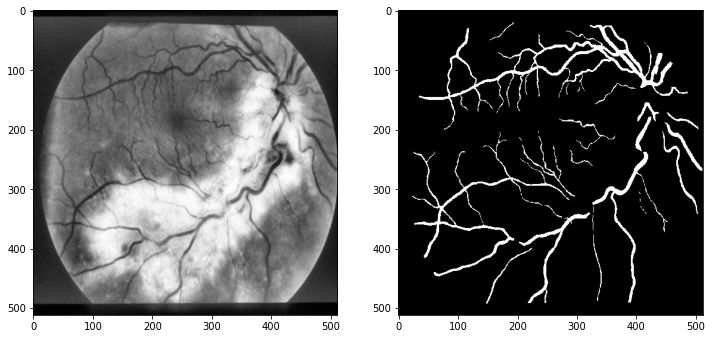

In [9]:
import random

image_number = random.randint(0, len(X_train)-1)
print(image_number)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')

plt.show()

In [10]:
def adjust_data(image, mask):
    """
        Some adjusting...
    """
    return (image, mask)


def train_generator(images, masks, aug_param:dict, batch_size:int):
    image_datagen = ImageDataGenerator(**aug_param)
    mask_datagen = ImageDataGenerator(**aug_param)
    image_generator = image_datagen.flow(
        images,
        seed = 1,
        batch_size = 3
    )
    mask_generator = mask_datagen.flow(
        masks,
        seed = 1,
        batch_size = 3
    )
    train_generator = zip(image_generator, mask_generator)
    for image, mask in train_generator:
        image, mask = adjust_data(image, mask)
        yield(image, mask)

In [11]:
datagen_args = dict(
    rotation_range = 0.3,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    shear_range = 0.1,
    zoom_range = [0.7,1],
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.2,
)

batch_size = 3
seed = 1

datagen = train_generator(X_train, y_train, datagen_args, batch_size)

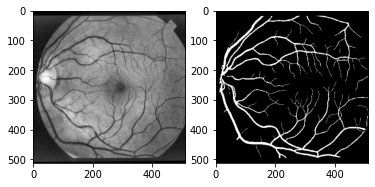

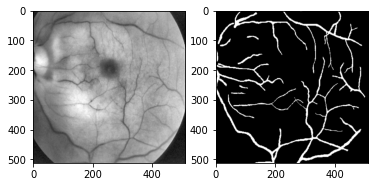

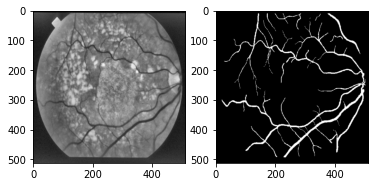

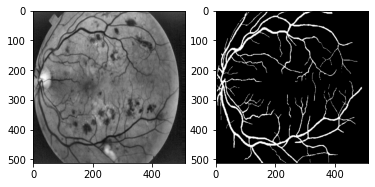

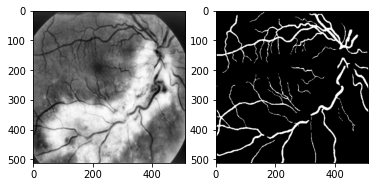

In [12]:
plt.figure()

for _ in range(5):
    img, label = next(datagen)
    plt.subplot(121)
    plt.imshow(img[0], cmap='gray')
    plt.subplot(122)
    plt.imshow(label[0], cmap='gray')
    plt.show()

In [13]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

def unet(pretrained_weights = None, input_size = (512,512,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4, training=True)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5, training=True)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    

    if(pretrained_weights):
    	  model=keras.models.load_model(pretrained_weights)

    return model
     

In [14]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# batch_size = 5
# steps_per_epoch = int( np.ceil(X_train.shape[0] / batch_size) )

# print('batch size:', batch_size)
# print('step per epoch:', steps_per_epoch)

batch size: 5
step per epoch: 2


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

model = unet()
model_checkpoint = ModelCheckpoint('unet_STARE.hdf5', monitor='loss', verbose=1, save_best_only=True)
callbacks = [ model_checkpoint ]
history = model.fit(
    datagen,
    steps_per_epoch=10,
    epochs=80,
    verbose=0,
    callbacks=callbacks)


Epoch 1: loss improved from inf to 0.38999, saving model to unet_STARE.hdf5

Epoch 2: loss improved from 0.38999 to 0.22151, saving model to unet_STARE.hdf5

Epoch 3: loss improved from 0.22151 to 0.18552, saving model to unet_STARE.hdf5

Epoch 4: loss improved from 0.18552 to 0.15998, saving model to unet_STARE.hdf5

Epoch 5: loss improved from 0.15998 to 0.15208, saving model to unet_STARE.hdf5

Epoch 6: loss improved from 0.15208 to 0.14664, saving model to unet_STARE.hdf5

Epoch 7: loss did not improve from 0.14664

Epoch 8: loss improved from 0.14664 to 0.13940, saving model to unet_STARE.hdf5

Epoch 9: loss did not improve from 0.13940

Epoch 10: loss improved from 0.13940 to 0.13701, saving model to unet_STARE.hdf5

Epoch 11: loss improved from 0.13701 to 0.13487, saving model to unet_STARE.hdf5

Epoch 12: loss improved from 0.13487 to 0.12739, saving model to unet_STARE.hdf5

Epoch 13: loss improved from 0.12739 to 0.12716, saving model to unet_STARE.hdf5

Epoch 14: loss impro

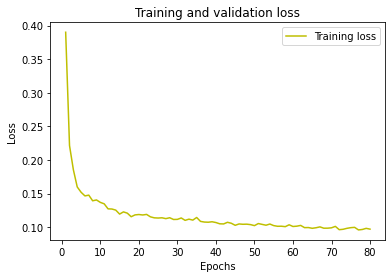

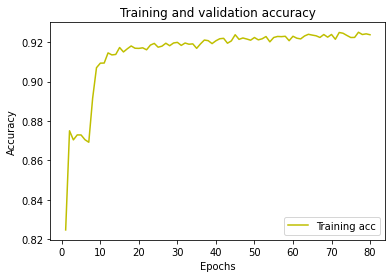

In [18]:
loss = history.history['loss']
# val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

(1, 512, 512, 1)
1/1 [==============================] - 4s 4s/step
(512, 512)


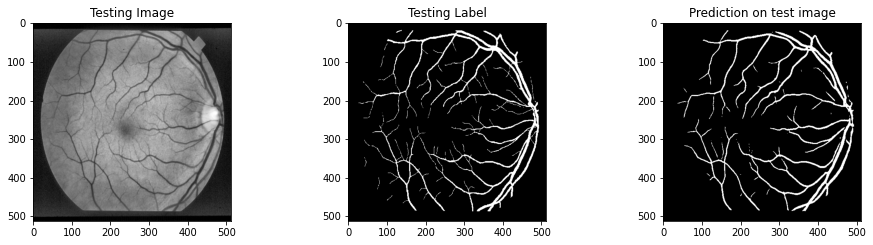

In [19]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
